# Investigating the effects of energy threshold and uncertainties

In [1]:
import numpy as np
import stan_utility
import h5py
from matplotlib import pyplot as plt

from joint_model_cascades import luminosity_distance, Mpc_to_m

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
random_seed = 19920715

## Simplified toy model
Try to treat Aeff and P(Edet|E) as simple functions to understand and tackle full problem.

In [3]:
# Functions
AEFF_EMAX = 1e5
AEFF_EMIN = 2e3

def dNdE(E, alpha):
    return E**(-alpha)

def spectrum_rng(Emin, alpha):
    upper_lim = dNdE(Emin, alpha)
    lower_lim = dNdE(Emin*1e4, alpha)
    accepted = False
    while not accepted:
        E = np.random.uniform(Emin, Emin*1e4)
        p = np.random.uniform(lower_lim, upper_lim)
        if (p < dNdE(E, alpha)):
            accepted = True           
    return E

def effective_area(E):
    if E < AEFF_EMIN or E > AEFF_EMAX:
        return 0
    else:
        return 5*(E/AEFF_EMIN)**0.5 # m^2
    
def interaction_probability(E):
    return effective_area(E)/effective_area(AEFF_EMAX)

### Effective area 

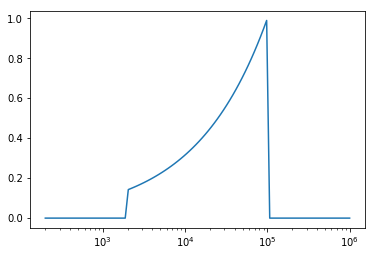

In [4]:
Egrid = np.logspace(np.log(AEFF_EMIN/10), np.log(AEFF_EMAX*10), 100, base=np.e)
fig, ax = plt.subplots()
#ax.plot(Egrid, [effective_area(_) for _ in Egrid])
ax.plot(Egrid, [interaction_probability(_) for _ in Egrid])
ax.set_xscale('log')

### Exposure integral

In [5]:
from scipy.stats import lognorm
from scipy import integrate

In [6]:
# Functions
def p_gt_Eth(E, Eth, f_E):
    return 1 - lognorm.cdf(Eth, f_E, 0, E)

def integrand(E, Eth, f_E, Emin, alpha):
    return (  p_gt_Eth(E, Eth, f_E) * effective_area(E) * (E / Emin)**(-alpha)  )

def old_integrand(E, Eth, f_E, Emin, alpha):
    return ( effective_area(E) * (E / Emin)**(-alpha)  )

### Input parameters

In [31]:
Emin = 1e3 # GeV
Eth = 5e3 # GeV

alpha = 2.5
T = 1 # yr
N = 1000
F_N = (N / T) / effective_area(1e5) # m^-2 yr^-1
f_E = 0.5

In [32]:
# Exposure integral calculation
alpha_grid = np.linspace(1.5, 3.5, 100)
integral_grid = []
for a in alpha_grid:
    integ, err = integrate.quad(integrand, AEFF_EMIN, AEFF_EMAX, 
                                args=(Eth, f_E, Eth, a))
    integral_grid.append(integ)

### Simulation

In [33]:
# Source
Esrc = np.array([spectrum_rng(Emin, alpha) for _ in range(N)])

# Effective area 
int_prob = [interaction_probability(_) for _ in Esrc]
interacted_in_detector = np.zeros(len(int_prob))
for i, p in enumerate(int_prob):
    interacted_in_detector[i] = np.random.choice([0, 1], p=[1-p, p])    
E = Esrc[np.where(interacted_in_detector == 1.0)]

# Detection effects
Edet_s = np.array([np.random.lognormal(np.log(_), f_E) for _ in E])

# Thresholding
Edet = Edet_s[np.where(Edet_s >= Eth)]

38 events above threshold


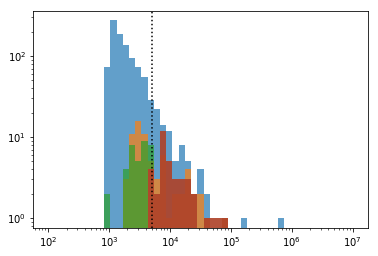

In [34]:
fig, ax = plt.subplots()
bins = np.logspace(np.log(1e2), np.log(1e7), base=np.e)
ax.hist(Esrc, bins=bins, alpha=0.7)
ax.hist(E, bins=bins, alpha=0.7)
ax.hist(Edet_s, bins=bins, alpha=0.7)
ax.hist(Edet, bins=bins, alpha=0.7)
ax.axvline(Eth, linestyle=':', color='k')
ax.plot()
ax.set_xscale('log')
ax.set_yscale('log')
print(len(Edet), 'events above threshold')

### Fit

In [35]:
# Compile the model
model = stan_utility.compile_model(filename = 'stan/test_Eth.stan', 
                                   model_name = 'test_Eth_model', 
                                   include_paths = 'stan/')

Using cached StanModel


In [36]:
fit_input = {}
fit_input['Nevents'] = len(Edet)
fit_input['Edet'] = Edet 

#fit_input['Emin'] = Emin
fit_input['Emin'] = Eth # use threshold -> approximate
#fit_input['Emin'] = AEFF_EMIN # interp case

fit_input['f_E'] = f_E
fit_input['T'] = T # yr

fit_input['Ngrid'] = len(alpha_grid)
fit_input['alpha_grid'] = alpha_grid
fit_input['integral_grid'] = integral_grid

In [37]:
fit = model.sampling(data = fit_input, iter = 1000, chains = 4, seed = random_seed)

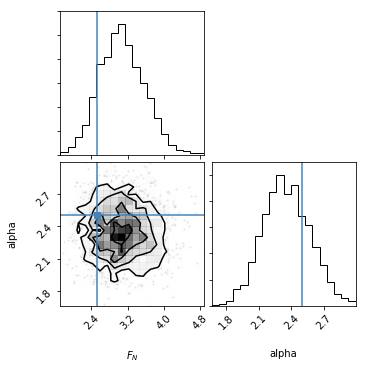

In [38]:
import corner
efac = (fit_input['Emin']/Emin)**(1-alpha)
chain = fit.extract(permuted = True)
key_list = ['F_N', 'alpha']
labels = [r'$F_N$', 'alpha']
truths = [F_N * efac, alpha]
#truths = [F_N, alpha]

corner.corner(np.nan_to_num(np.column_stack([chain[key] for key in key_list])),
              labels = labels, 
              truths = truths);

### Energy uncertainties

In [ ]:
# P(E>Edet | E)
from scipy.stats import norm, lognorm
from scipy import optimize

def p_gt_Eth(E, f_E, Eth):
    return 1 - lognorm.cdf(Eth, f_E, 0, E)

def get_min_bound(f_E, Eth):
    fac=10*f_E
    E = optimize.fsolve(p_gt_Eth, Eth/fac, args=(f_E, Eth))
    return round(E[0])

f_E = [0.2, 0.5, 1.0]
E = np.logspace(np.log(1e2), np.log(1e5), 1000, base=np.e)

fig, ax = plt.subplots()
for __ in f_E:
    p = [p_gt_Eth(_, __, Eth) for _ in E]
    b = get_min_bound(__, Eth)
    ax.plot(E, p, label='$\sigma$ = '+str(__))
    #ax.axvline(b, linestyle=':', color='k')
ax.axvline(Eth, linestyle=':', color='k', label='$E_\mathrm{th}$')
ax.set_xlabel('$E$ / GeV', fontsize=14)
ax.set_ylabel('$P(E_\mathrm{det} > E_\mathrm{th} | E)$', fontsize=14)
ax.set_xscale('log')
ax.legend(fontsize=14)

# Full simulation down to low energies

In order to simulate a realistic scenario, simulate down to low energies, then make a cut on the detected energies.

In [ ]:
from aeff_calculator.aeff_calculator import effective_area

In [ ]:
# Use a set of sources uniform in comoving volume for a lambda-CDM universe.
with h5py.File('../data/test_SFR_pop.h5', 'r') as f:
    Ns = f['output/Ns'].value
    redshift = f['output/redshift'].value
    position = f['output/position'].value
    
# Select sources within redshift zth to mimic catalogue
zth = 1
selection = np.where(redshift < zth)[0]
Ns = len(selection)
redshift = np.array([redshift[_] for _ in selection])
position = np.array([position[_] for _ in selection])
unit_vector = [p / np.linalg.norm(p) for p in position]

# Add background redshift
redshift = list(redshift) + [zth]

In [ ]:
# Effective area
from scipy.interpolate import RectBivariateSpline

aeff = effective_area("nue_CC")

# Get input for spline evaluation in Stan
p = 3  # spline degree (default in RectBivariateSpline)
xknots, yknots = aeff.spline.get_knots()
c = aeff.spline.get_coeffs()

xknots = np.unique(xknots)
yknots = np.unique(yknots)
Nx = len(xknots)+p-1 
Ny = len(yknots)+p-1 
c = c.reshape(Nx, Ny)

# Maximum of the effective area, to scale 
aeff_max_tot = max(10**aeff.aeff_vals) # m^2

In [ ]:
Ebins = np.linspace(3.0, 7.0, 1000)
aeff_max = []
for uv in unit_vector:
    cosz = np.cos(np.pi - np.arccos(uv[2]))
    aeff_at_uv = [10**aeff.eval(_, cosz)[0][0] for _ in Ebins]
    aeff_max.append(max(aeff_at_uv))
aeff_max.append(aeff_max_tot)

In [ ]:
# Prepare simulation inputs that are defined above
sim_input = {}

# Sources
sim_input['Ns'] = Ns
sim_input['z'] = redshift
sim_input['D'] = [luminosity_distance(z) for z in redshift[:-1]] # Mpc
sim_input['varpi'] = unit_vector

# Aeff Spline
sim_input['p'] = p
sim_input['Lknots_x'] = len(xknots)
sim_input['Lknots_y'] = len(yknots)
sim_input['xknots'] = xknots
sim_input['yknots'] = yknots
sim_input['c'] = c
sim_input['aeff_max'] = aeff_max

In [ ]:
# Energies
sim_input['alpha'] = 2.0
sim_input['Emin'] = 1e4 # Emin_sim
Eth = 1e4 # GeV
E_scale = (Eth / sim_input['Emin'])**(1-sim_input['alpha'])
sim_input['f_E'] = 0.1

# Reconstruction 
sim_input['kappa'] = 100 # ~10 deg for cascades

# Associated fraction  (derived paramaters, but easier to define this way)
total_flux = 1e2 # m^-2 yr^-1
f = 0.5

sim_input['T'] = 1 # yr
sim_input['F0'] = (1 - f) * total_flux # m^-2 yr^-1
sim_input['Q'] = ( (f*total_flux) / (sum([1 / (4*np.pi * (d*Mpc_to_m)**2) 
                                          for d in sim_input['D']])) ) # yr^-1 
print('F0:', sim_input['F0'])

In [ ]:
# Compile Stan model
sim = stan_utility.compile_model(filename = 'stan/joint_cascade_sim_Eth_alt.stan', 
                                 model_name = 'Eth_sim_alt', include_paths = 'stan/')

In [ ]:
# Simulate
simulation = sim.sampling(data=sim_input, iter=1, chains=1, 
                          algorithm="Fixed_param")#, seed=random_seed)
# Fast extract
N_sim = int(simulation.extract(['N_sim'])['N_sim'])
spec = {'lambda': N_sim, 'omega': 3, 'Esrc': N_sim, 'E': N_sim, 'Edet': N_sim,
        'zenith': N_sim, 'pdet': N_sim, 'prob': 2, 'event': (3, N_sim), 'Nex_sim': 1, 
        'N_sim': 1, 'detected': N_sim, 'log10E': 1, 'cosz': 1}
chain = stan_utility.utils.fast_extract(simulation, spec)

In [ ]:
# Energies
Esrc = chain['Esrc']
Edet = chain['Edet']

detected = chain['detected']
det = np.where(detected == 1)[0]
th = np.where(Edet >= Eth)[0]
selection = np.intersect1d(det, th)

# filter out detected
Edet = Edet[selection]

print(len(Edet), 'events above threshold energy out of', len(Esrc), 'total events')

In [ ]:
# Arrival directions
from fancy.interfaces.stan import Direction
from fancy.plotting import AllSkyMap

event = chain['event'].T
event = event[selection]
event = Direction(event)
e_ra = event.d.icrs.ra.rad
e_dec = event.d.icrs.dec.rad

source = Direction(unit_vector)
s_ra = source.d.icrs.ra.rad
s_dec = source.d.icrs.dec.rad

# Labels
lam = chain['lambda'] - 1
lam = lam[selection]
lam = list(lam)
Nc = Ns
label_cmap = plt.cm.get_cmap('plasma', Nc+1)
Nsrc = sum([lam.count(_) for _ in range(int(Nc))])
Nbg = lam.count(Nc)
print('Nsrc: ', Nsrc)
print('Nbg: ', Nbg)
print('w_bg: ', Nbg / (Nbg+Nsrc))

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

fig, ax = plt.subplots()
fig.set_size_inches((10, 8))
skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0);
for r, d, l in zip(e_ra, e_dec, lam):
    color = label_cmap.colors[int(l)]
    skymap.tissot(np.rad2deg(r), np.rad2deg(d), 2, 30, color = color, alpha = 0.7)
norm = max([1 - _/zth for _ in redshift])
for r, d, z in zip(s_ra, s_dec, redshift):
    skymap.tissot(np.rad2deg(r), np.rad2deg(d), 2, 30, color = 'black', 
                  alpha = (1 - z/zth)/norm)

In [ ]:
# Plot energies
Emin = sim_input['Emin']
bins = np.logspace(np.log(Emin), np.log(1E+4*Emin), base = np.e)

fig, ax = plt.subplots()
ax.hist(Esrc, bins=bins, label='$\\tilde{E}$', alpha=0.7);
ax.hist(chain['E'][selection], bins=bins, alpha=0.7)
ax.hist(Edet, bins=bins, label='$\hat{E}$', alpha=0.7);
ax.axvline(Eth, linestyle=":", color='k')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / GeV')
ax.legend();

In [ ]:
print((1+min(redshift)) * sim_input['Emin'])
print(min(Esrc))

## Fitting the model

In [ ]:
# Get precomputed eps factor
with h5py.File('data/precomputed_integral_1e4_100_nouncert.h5', 'r') as f5:
    alpha_grid = f5['alpha_grid'].value
    integral_grid = f5['integral_grid'].value

In [ ]:
# Prepare fit inputs
fit_input = {}
fit_input['N'] = len(event.unit_vector)
fit_input['omega_det'] = event.unit_vector
fit_input['Emin'] = Eth # Emin as Eth -> approximate!
fit_input['f_E'] = sim_input['f_E']
fit_input['Edet'] = Edet
fit_input['Ns'] = Ns
fit_input['varpi'] = source.unit_vector
fit_input['D'] = sim_input['D']
fit_input['z'] = sim_input['z']
fit_input['kappa'] = sim_input['kappa']

# Exposure
fit_input['Ngrid'] = len(alpha_grid)
fit_input['alpha_grid'] = alpha_grid
fit_input['integral_grid'] = integral_grid
fit_input['T'] = sim_input['T']

# Debugging
fit_input['Q_scale'] = sim_input['Q'] * E_scale
fit_input['F0_scale'] = sim_input['F0'] * E_scale

In [ ]:
# Compile the model
model = stan_utility.compile_model(filename = 'stan/joint_cascade_model_Eth.stan', 
                                   model_name = 'Eth_model', 
                                   include_paths = 'stan/')

In [ ]:
fit = model.sampling(data = fit_input, iter = 1000, chains = 4, seed = random_seed)

In [ ]:
# View chains
fig = fit.plot([r'Q', r'F0', r'f', r'alpha', r'F']);
fig.set_size_inches(20, 16)
fig.tight_layout()

In [ ]:
import corner
# View corner plot
chain = fit.extract(permuted = True)
key_list = ['F0', 'Q', 'FT', 'f', 'alpha']
labels = [r'$F_0$', r'Q', r'FT', r'f', 'alpha']
truths = [sim_input['F0'] * E_scale , sim_input['Q'] * E_scale, total_flux * E_scale, f, sim_input['alpha']]

corner.corner(np.nan_to_num(np.column_stack([chain[key] for key in key_list])),
              labels = labels, 
              truths = truths);

In [ ]:
# Think relative spectral spacing is the problem...
print(1e4*(1+1) - 1e4*(1+0.4))
print(1e3*(1+1) - 1e3*(1+0.4))